In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS
import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh

from cli import get_file_paths

In [4]:
site_key = 'Central'
freq_key = 'hf_'

In [5]:
bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

In [6]:
fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 2000

In [7]:
print(f'Looking at {fig_details["site_name"]}')

Looking at Central Pond


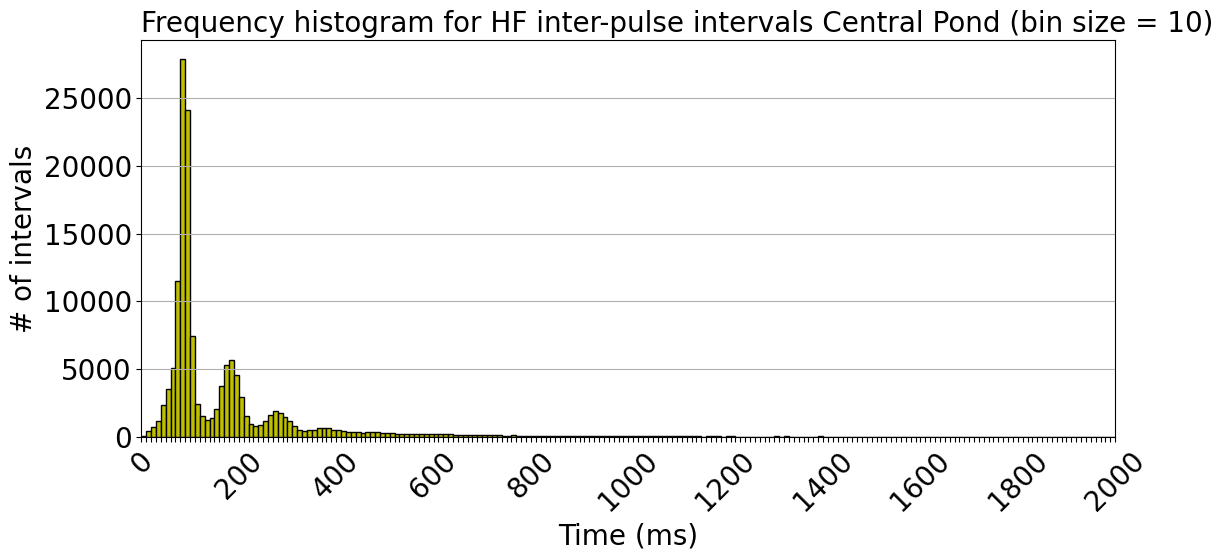

In [8]:
location_df = pd.read_csv(f'../data/2022_bd2_summary/Central/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022.csv', index_col=0)
ipis_f, hist_f = bt_plt.plot_ipi_hist(location_df, fig_details)

In [9]:
location_df = pd.read_csv(f'../data/2022_bd2_summary/Central/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022.csv', index_col=0)
ipis_loc, hist_loc = bt_clustering.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = bt_clustering.get_log_survival(hist_loc)

fast_process = bt_clustering.regress_around_peakIPI(intervals_ms, survival, hist_loc[0])
fast_process = bt_clustering.calculate_exponential_coefficients(fast_process)

slow_process = bt_clustering.regress_around_slow_intervals(intervals_ms, survival)
slow_process = bt_clustering.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = bt_clustering.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = bt_clustering.get_bci_from_slater_method(fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = bt_clustering.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")

Fagen&Young method has 690881895 missassigned points
Slater method has 1197269 missassigned points
Sibly method has 1168593 missassigned points
Optim BCI has less misassignments than BCI? True
28675 more points assigned correctly


In [10]:
fast_process, slow_process

({'metrics': LinregressResult(slope=-0.005374321335380192, intercept=11.986344541265428, rvalue=-0.9758745050555953, pvalue=2.1842153430154122e-27, stderr=0.00019253742035449468, intercept_stderr=0.04474165335328169),
  'indices': range(0, 41),
  'lambda': 0.005374321335380192,
  'num_intervals_slater': 29873056.669806562},
 {'metrics': LinregressResult(slope=-1.5506784156556664e-06, intercept=6.976661412561185, rvalue=-0.9942437178754373, pvalue=0.0, stderr=5.990036566182227e-10, intercept_stderr=0.0010651839058896865),
  'indices': array([False, False, False, ..., False, False, False]),
  'lambda': 1.5506784156556664e-06,
  'num_intervals_slater': 690881894.7693554})

In [11]:
nlin_results

{'solution': array([2.92109085e+07, 5.50838418e-03, 6.90888260e+08, 1.55068644e-06]),
 'fast_num_intervals': 29210908.51806591,
 'fast_lambda': 0.005508384184123229,
 'slow_num_intervals': 690888260.3281283,
 'slow_lambda': 1.5506864431679824e-06,
 'bci': 910.1224915692399}

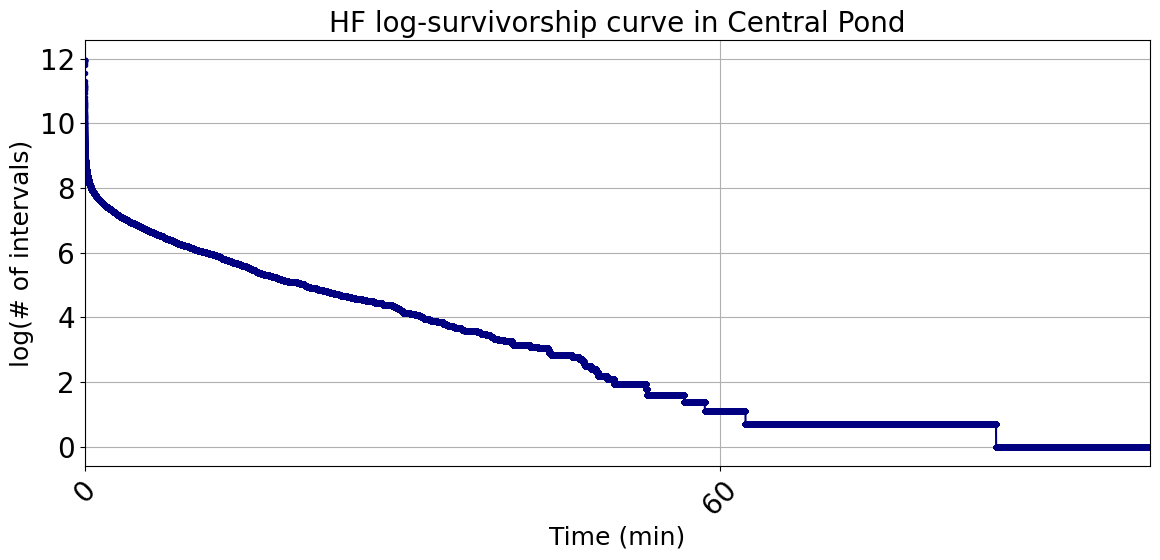

In [12]:
bt_plt.plot_log_survival(intervals_ms, survival, fig_details)

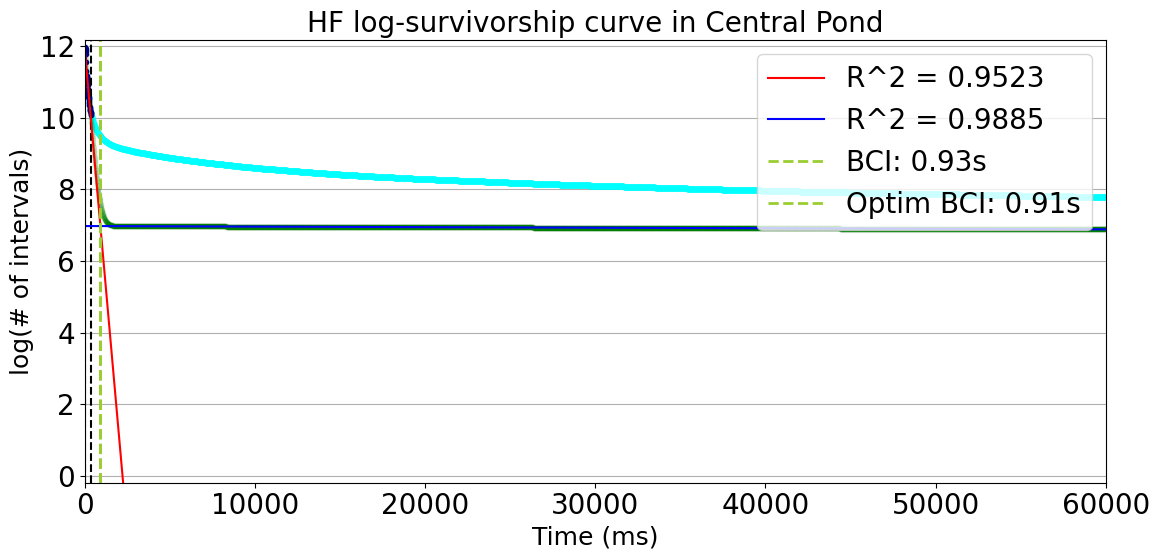

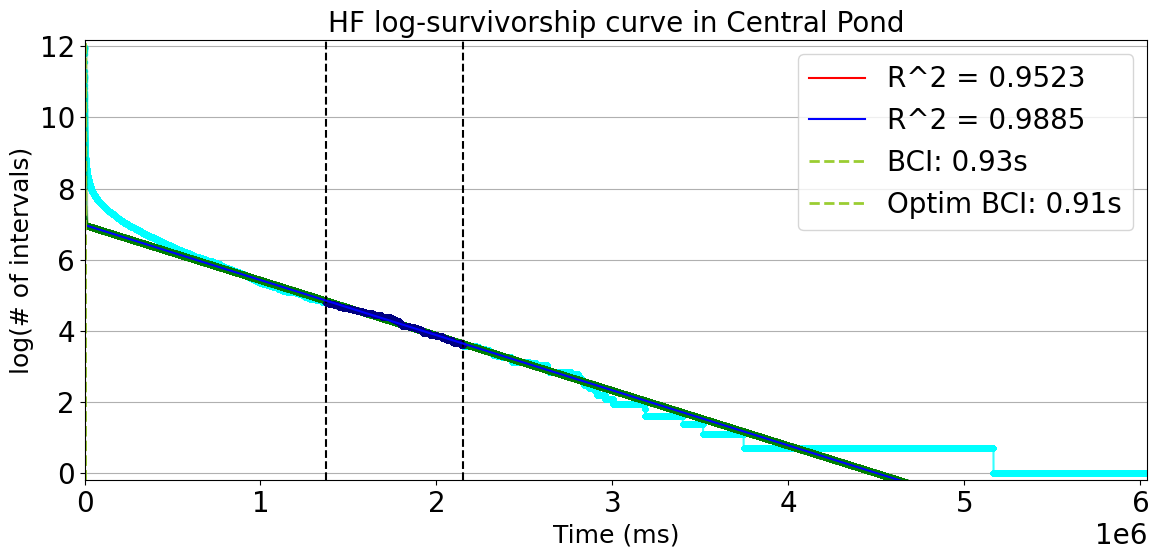

In [13]:
fig_details['time_end'] = 60000
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

In [45]:
filename = '20220826_070000'
file_path = Path(f'../../Documents/Research/Symposium/Recordings/recover-20220828/UBNA_010/{filename}.WAV')
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 660
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 50 # hide anything below -rm_dB dB

bout_params['bci'] = nlin_results['bci']

data_params = dict()
data_params['dc_tag'] = '1800of1800'
data_params['freq_tags'] = FREQ_GROUPS[bout_params['freq_key']]

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path(f'../data/raw/{bout_params["site_key"]}/bd2__{bout_params["site_key"]}_{filename}.csv')
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['dc_tag'])
batdetect2_preds_with_bouttags = bt_clustering.classify_bouts_in_single_bd2_output(batdetect2_predictions, bout_params)
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
bout_metrics = bt_clustering.construct_bout_metrics_from_classified_dets(batdetect2_preds_with_bouttags)
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

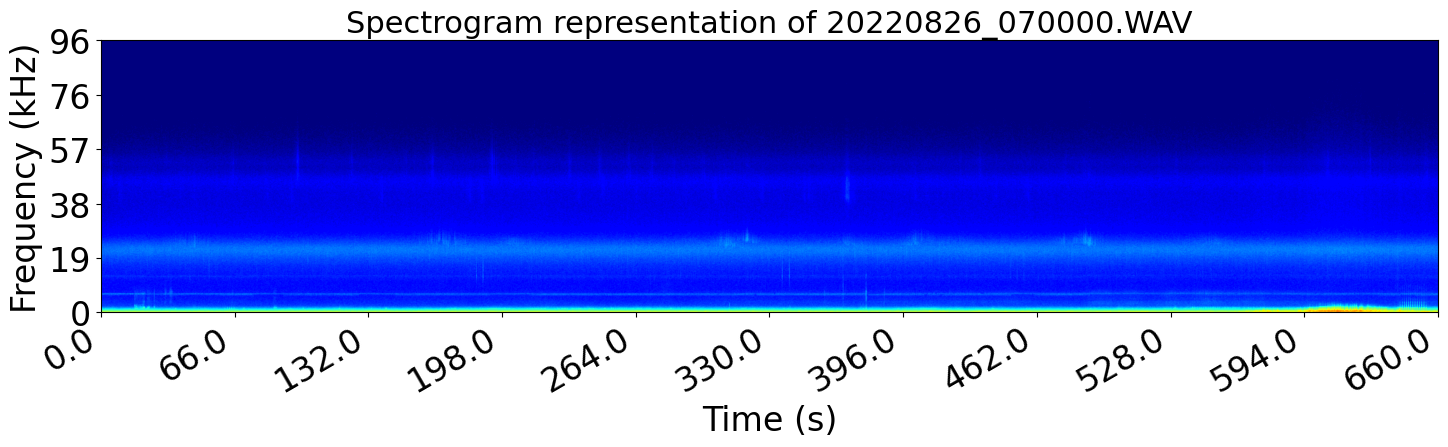

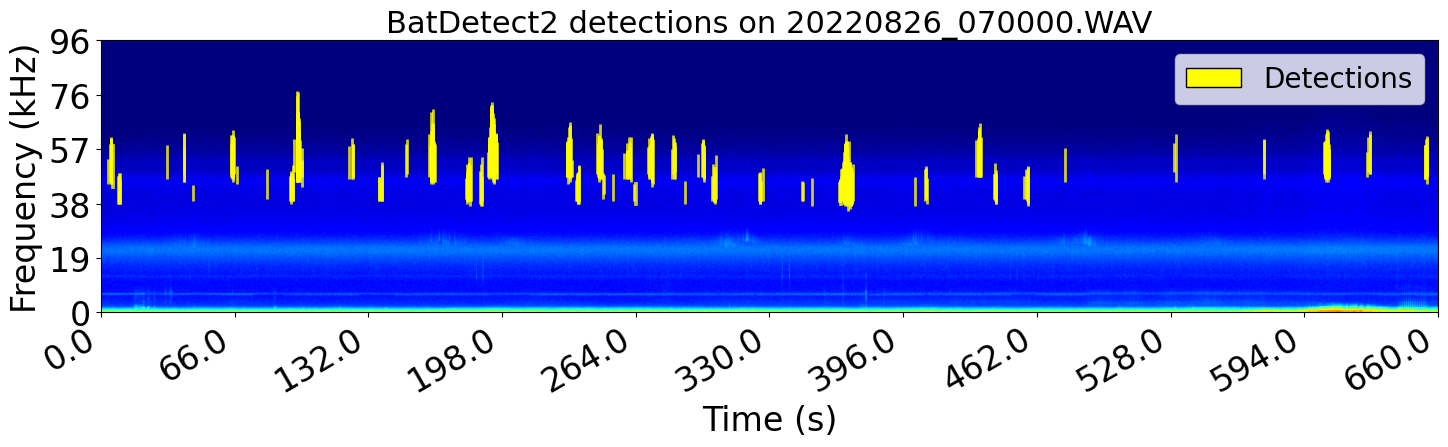

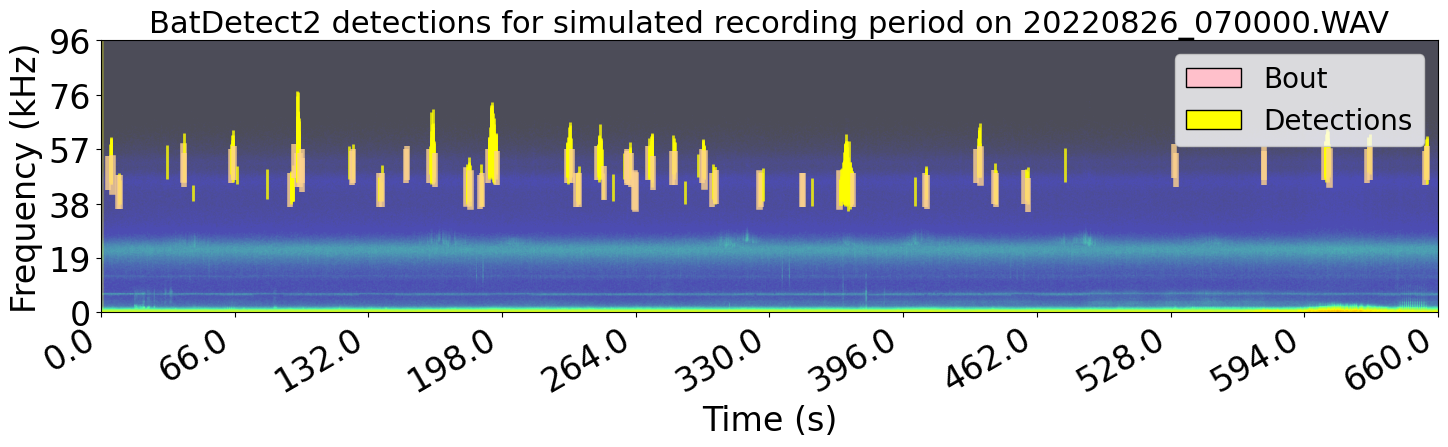

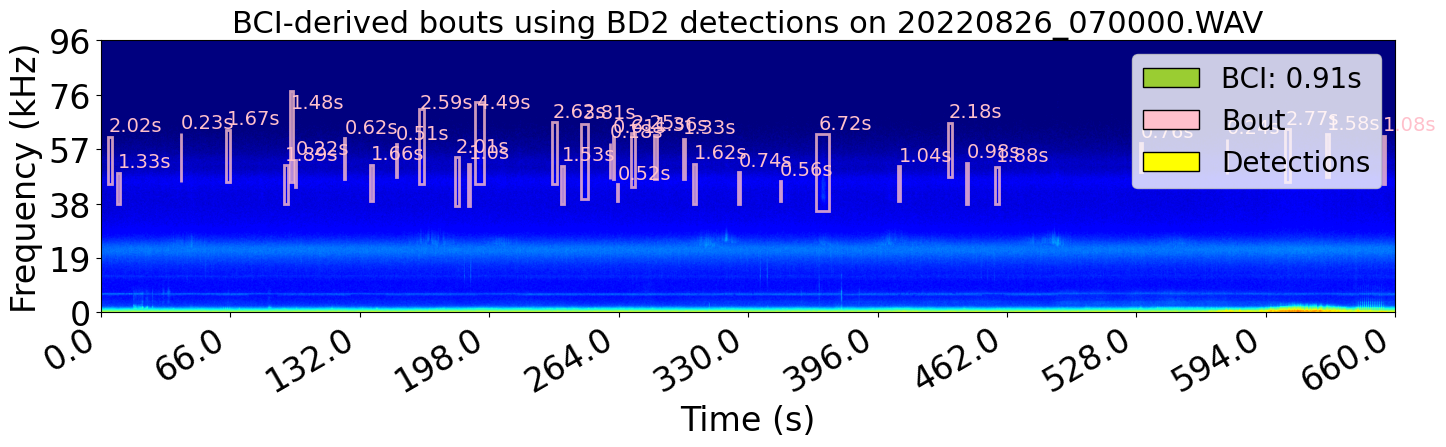

In [46]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

In [47]:
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 600
duration = 660
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

bout_params['bci'] = nlin_results['bci']

data_params = dict()
data_params['dc_tag'] = '1800of1800'
data_params['freq_tags'] = FREQ_GROUPS[bout_params['freq_key']]

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

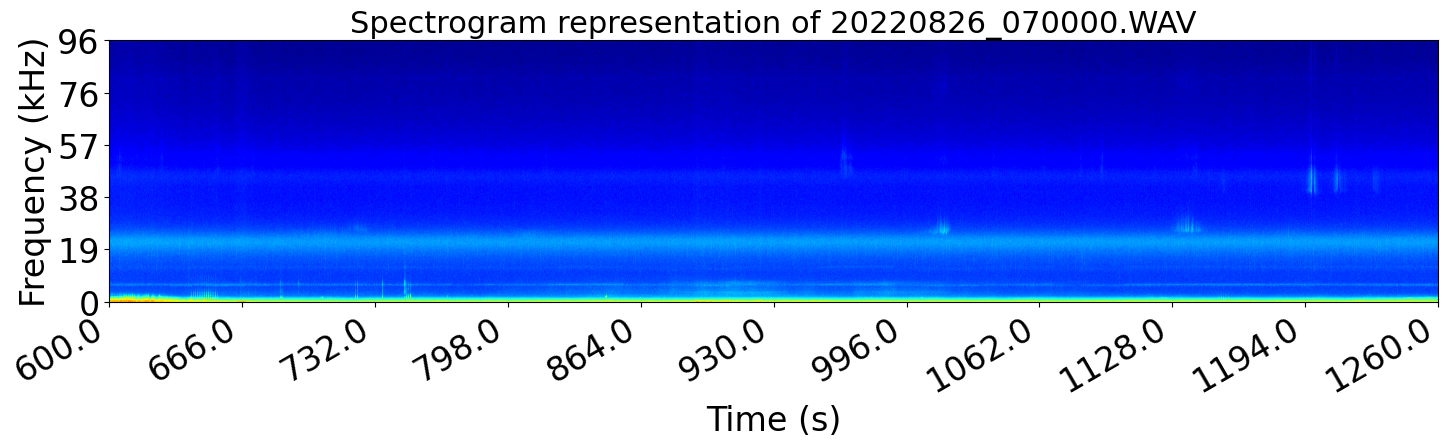

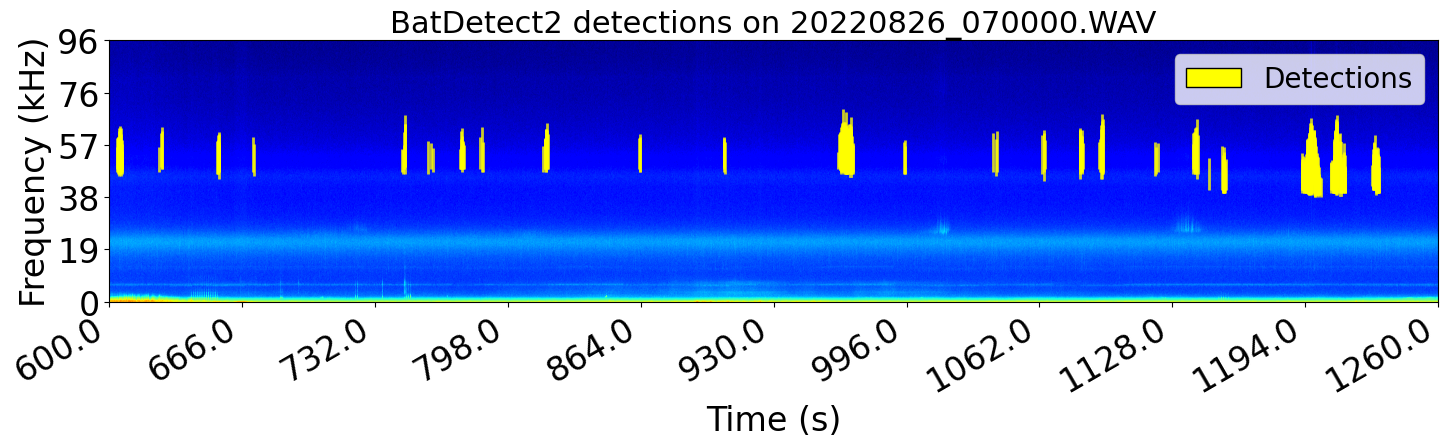

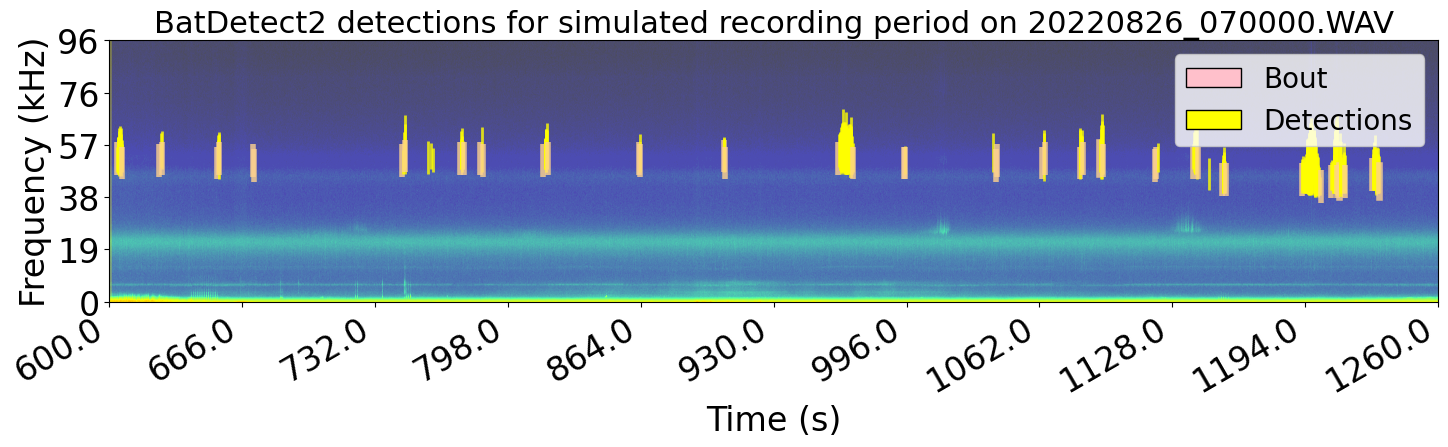

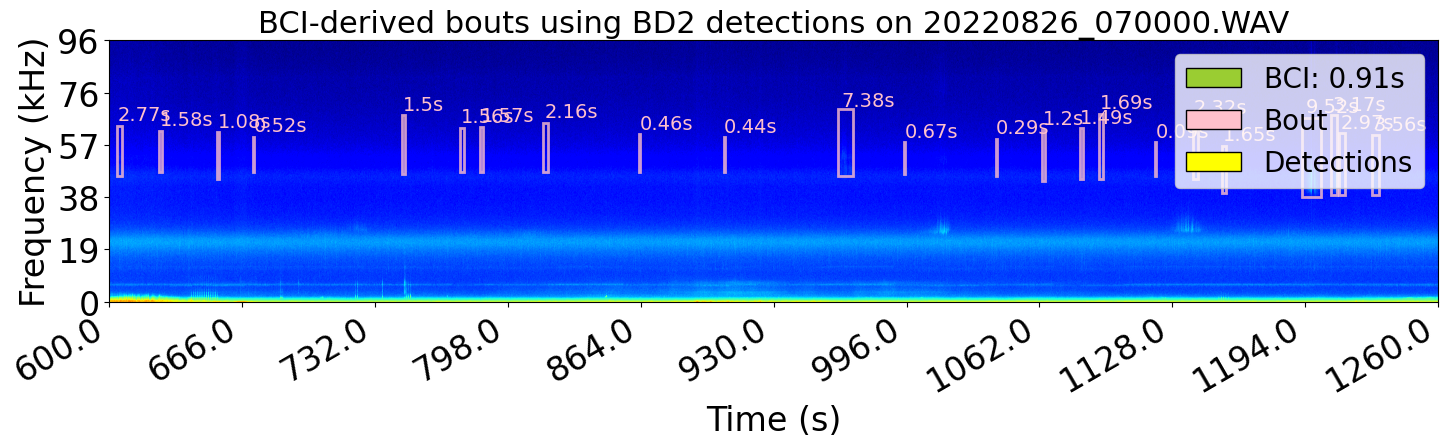

In [48]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

In [49]:
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 1200
duration = 600
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 50 # hide anything below -rm_dB dB

bout_params['bci'] = nlin_results['bci']

data_params = dict()
data_params['dc_tag'] = '1800of1800'
data_params['freq_tags'] = FREQ_GROUPS[bout_params['freq_key']]

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

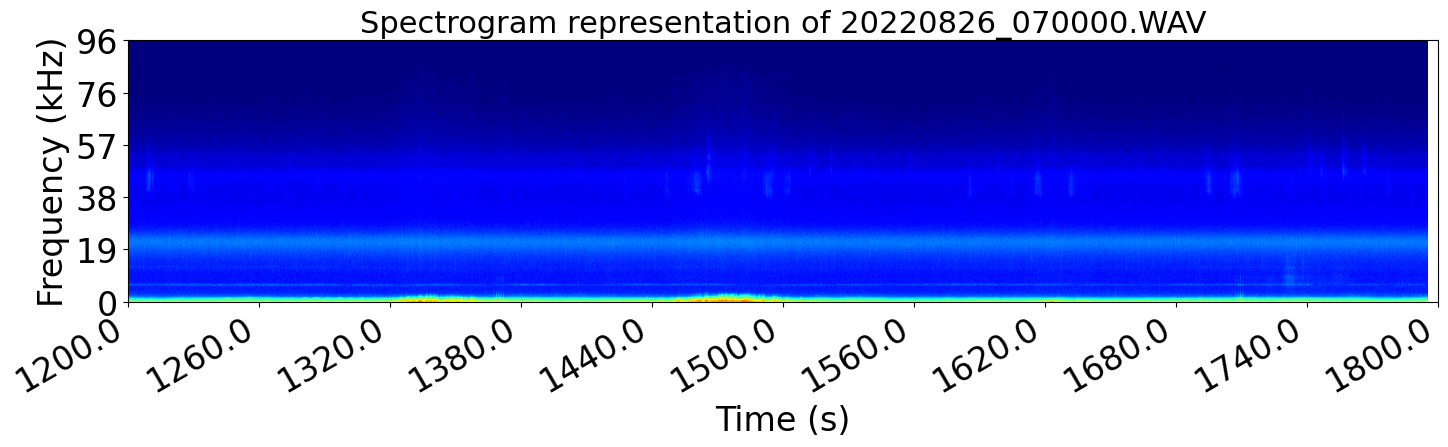

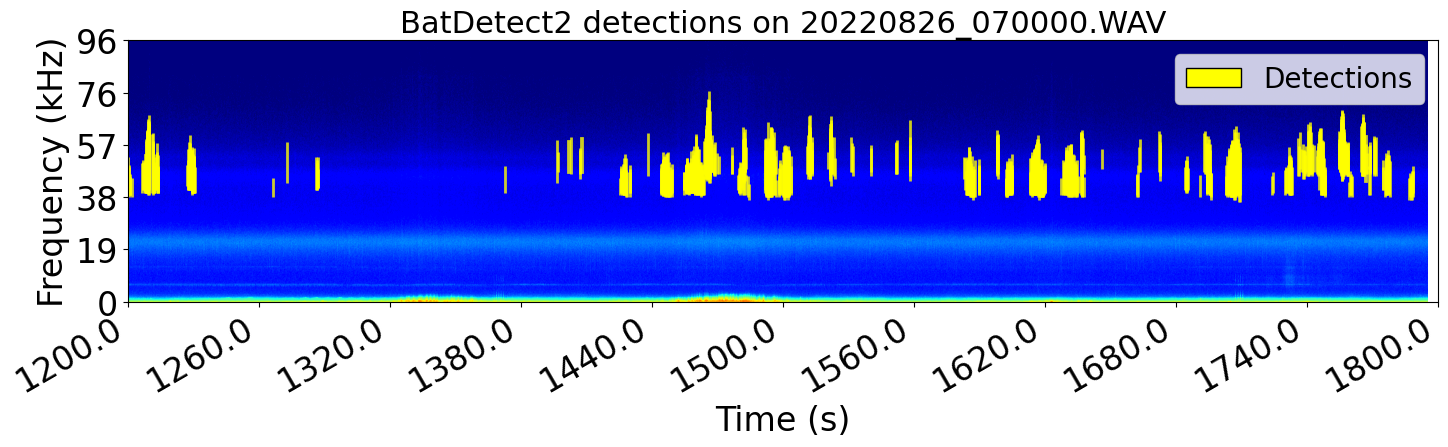

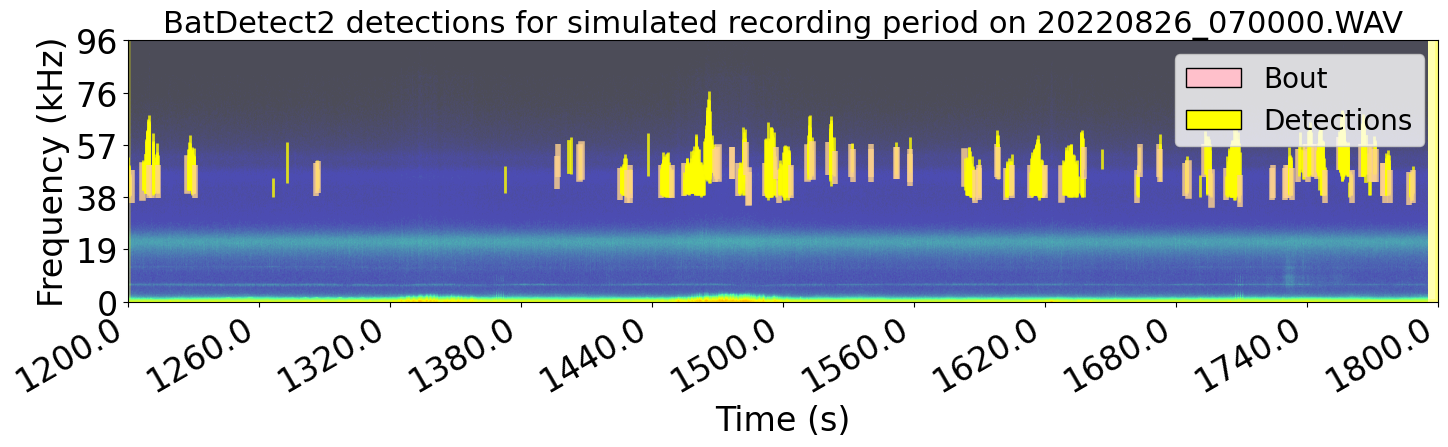

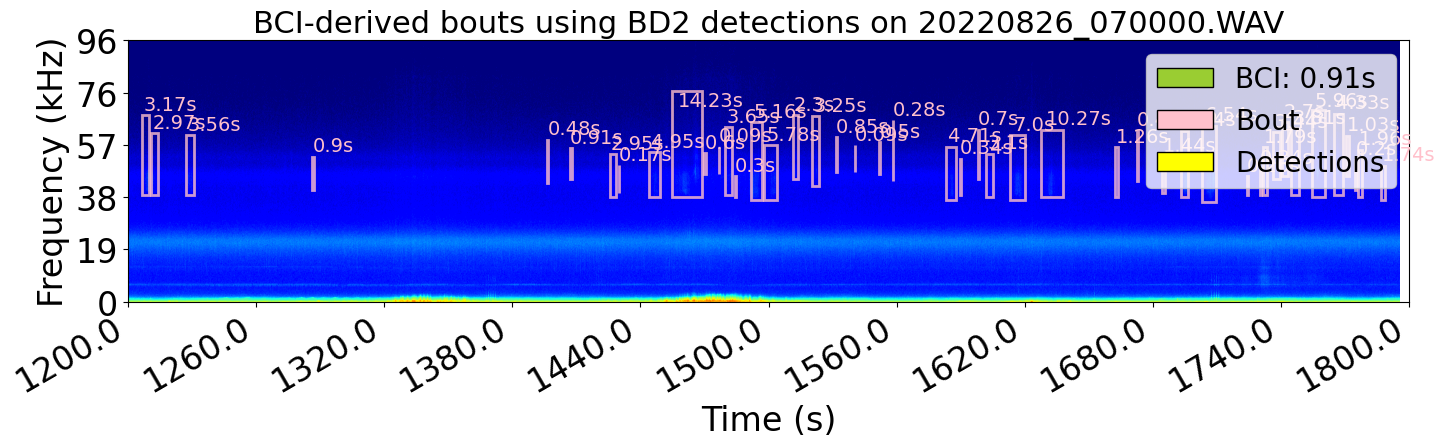

In [50]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

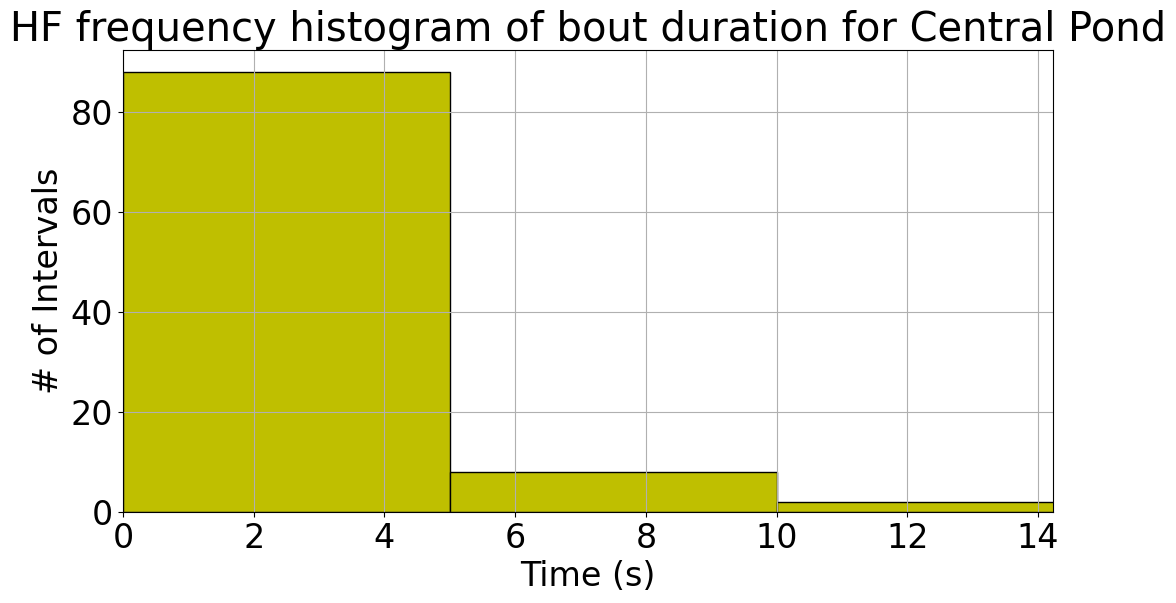

In [20]:
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['dc_tag'])
batdetect2_preds_with_bouttags = bt_clustering.classify_bouts_in_single_bd2_output(batdetect2_predictions, bout_params)
bout_metrics = bt_clustering.construct_bout_metrics_from_classified_dets(batdetect2_preds_with_bouttags)
bout_durations = bout_metrics['bout_duration_in_secs'].values
plt.figure(figsize=(12, 6))
plt.title(f"{fig_details['freq_group']}frequency histogram of bout duration for {fig_details['site_name']}")
plt.hist(bout_durations, bins=np.arange(0, bout_durations.max()+1, 5), facecolor='y', edgecolor='k')
plt.xlim(0,  bout_durations.max())
plt.xlabel('Time (s)')
plt.grid(which='both')
plt.ylabel('# of Intervals')
plt.show()

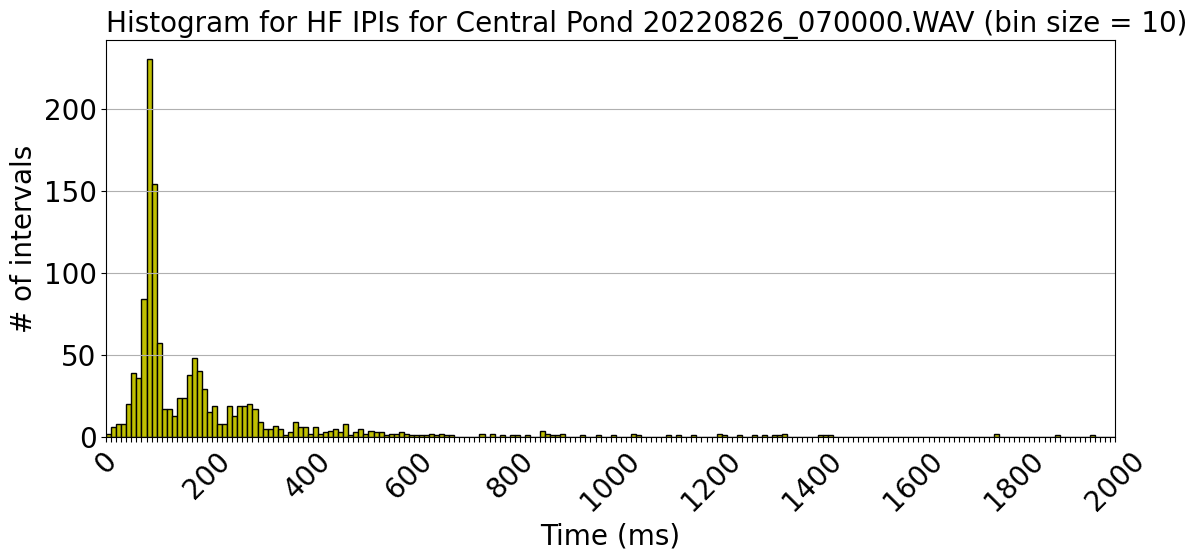

In [21]:
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
intervals = pd.to_datetime(batdetect2_predictions_no_dutycycle['call_start_time']) - pd.to_datetime(batdetect2_predictions_no_dutycycle['call_end_time']).shift(1)
batdetect2_predictions_no_dutycycle.insert(0, 'time_from_prev_call_end_time', intervals)
batdetect2_predictions_no_dutycycle = batdetect2_predictions_no_dutycycle.reset_index()
batdetect2_predictions_no_dutycycle.drop(columns=batdetect2_predictions_no_dutycycle.columns[0], inplace=True)

intervals = batdetect2_predictions_no_dutycycle['time_from_prev_call_end_time'].values
valid_intervals = intervals[~np.isnan(intervals)]
ipis_ms = valid_intervals.astype('float32')/1e6
assert((len(ipis_ms)+1) == len(batdetect2_predictions_no_dutycycle))

plt.rcParams.update({'font.size' : 20})
plt.figure(figsize=(12, 6))

fig_details['time_end'] = 2000

plt.title(f"Histogram for {fig_details['freq_group']}IPIs for {fig_details['site_name']} {file_path.name} (bin size = {fig_details['bin_step']})", loc='left', fontsize=20)
hist_bins = np.arange(0, fig_details['time_end']+fig_details['bin_step'], fig_details['bin_step'])
histogram = plt.hist(ipis_ms, bins=hist_bins, facecolor='y', edgecolor='k')
plt.grid(axis='y')
bin_ticks = hist_bins.round(3)
bin_labels = [''] * len(bin_ticks)
bin_labels[::int(fig_details['time_end']/(10*fig_details['bin_step']))] = bin_ticks[::int(fig_details['time_end']/(10*fig_details['bin_step']))]

plt.xticks(bin_ticks, bin_labels, rotation=45)
plt.ylabel('# of intervals', fontsize=20)
plt.xlabel('Time (ms)', fontsize=20)
plt.xlim(0, fig_details['time_end'])
plt.tight_layout()
plt.show()

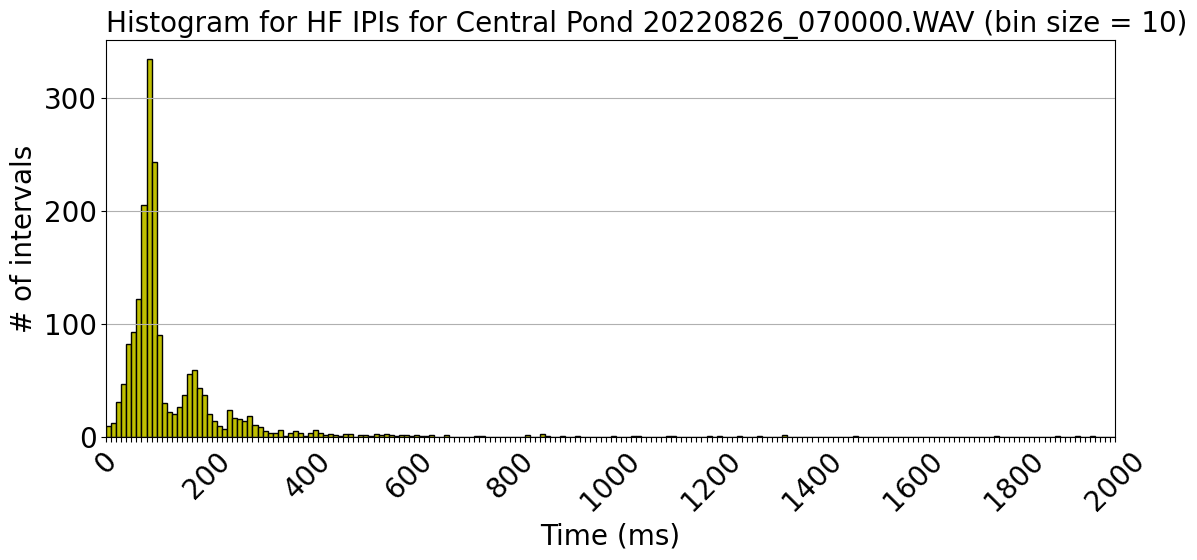

In [22]:
input_file = Path('../../Documents/Research/Symposium/Recordings/recover-20220828/UBNA_010/20220826_070000.WAV')

filename = input_file.name.split('.')[0]
original_file_dets = pd.read_csv(f'../../Downloads/human-UBNA_010_{filename}.txt', sep='\t')
original_file_dets['start_time'] = original_file_dets['Begin Time (s)']
original_file_dets['end_time'] = original_file_dets['End Time (s)']
original_file_dets['low_freq'] = original_file_dets['Low Freq (Hz)']
original_file_dets['high_freq'] = original_file_dets['High Freq (Hz)']
original_file_dets['input_file'] = filename
original_file_dets = original_file_dets.loc[original_file_dets['View']=='Spectrogram 1']

location_df = original_file_dets
file_dts = pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S', exact=False)

anchor_start_times = file_dts + pd.to_timedelta(location_df['start_time'].values.astype('float64'), unit='S')
anchor_end_times = file_dts + pd.to_timedelta(location_df['end_time'].values.astype('float64'), unit='S') 

location_df.insert(0, 'call_end_time', anchor_end_times)
location_df.insert(0, 'call_start_time', anchor_start_times)
location_df.insert(0, 'ref_time', anchor_start_times)

location_df = location_df.loc[(location_df["high_freq"]).astype('float64') < data_params["freq_tags"][1]]
location_df = location_df.loc[(location_df["low_freq"]).astype('float64') > data_params["freq_tags"][0]]

location_df = location_df.sort_values('ref_time')
location_df = location_df.reset_index()
location_df.drop(columns=location_df.columns[0], inplace=True)

intervals = pd.to_datetime(location_df['call_start_time']) - pd.to_datetime(location_df['call_end_time']).shift(1)
location_df.insert(0, 'time_from_prev_call_end_time', intervals)
location_df = location_df.reset_index()
location_df.drop(columns=location_df.columns[0], inplace=True)

intervals = location_df['time_from_prev_call_end_time'].values
valid_intervals = intervals[~np.isnan(intervals)]
ipis_ms = valid_intervals.astype('float32')/1e6
assert((len(ipis_ms)+1) == len(location_df))

plt.rcParams.update({'font.size' : 20})
plt.figure(figsize=(12, 6))

fig_details['time_end'] = 2000

plt.title(f"Histogram for {fig_details['freq_group']}IPIs for {fig_details['site_name']} {file_path.name} (bin size = {fig_details['bin_step']})", loc='left', fontsize=20)
hist_bins = np.arange(0, fig_details['time_end']+fig_details['bin_step'], fig_details['bin_step'])
histogram = plt.hist(ipis_ms, bins=hist_bins, facecolor='y', edgecolor='k')
plt.grid(axis='y')
bin_ticks = hist_bins.round(3)
bin_labels = [''] * len(bin_ticks)
bin_labels[::int(fig_details['time_end']/(10*fig_details['bin_step']))] = bin_ticks[::int(fig_details['time_end']/(10*fig_details['bin_step']))]

plt.xticks(bin_ticks, bin_labels, rotation=45)
plt.ylabel('# of intervals', fontsize=20)
plt.xlabel('Time (ms)', fontsize=20)
plt.xlim(0, fig_details['time_end'])
plt.tight_layout()
plt.show()